In [65]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
import pickle as pkl
from tqdm import tqdm
from math import sqrt

In [66]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [67]:
#oex_tickers = ["AAPL", "ABBV", "ABT", "ACN","ADBE","AIG", "ALL", "AMGN", "AMT", "AMZN", "AXP", "BA", "BAC","BIIB","BK","BKNG","BLK","BMY","C","CAT","CHTR","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX","DD","DHR","DIS","DUK","EMR","EXC","F","FB","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM","INTC","JNJ","JPM","KHC","KMI","KO","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE","NVDA","ORCL","OXY","PEP","PFE","PG","PM","PYPL","QCOM","RTX","SBUX","SLB","SO","SPG","T","TGT","TMO","UNH","UNP","UPS","USB","V","VZ","WBA","WFC","WMT","XOM"]

In [68]:
training_data = pd.read_csv('../dataset/insect/ant/time_series_chamber.csv')

In [69]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

In [70]:
def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [72]:
def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [73]:
from methods.svm import SVM
from preparers import ticker_default
from core.functions import forecast
from core.simulation import simulate_trades_continuous
from utils.viz import plot_time_series, plot_balance, plot_balance_vs_price
from utils.general import differentiate, inv_differentiate

# ARIMA

In [74]:
#from ant_migration import *
import pandas as pd
import numpy as np
import math
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima.model import ARIMA

time series of chamber and plot the distribution

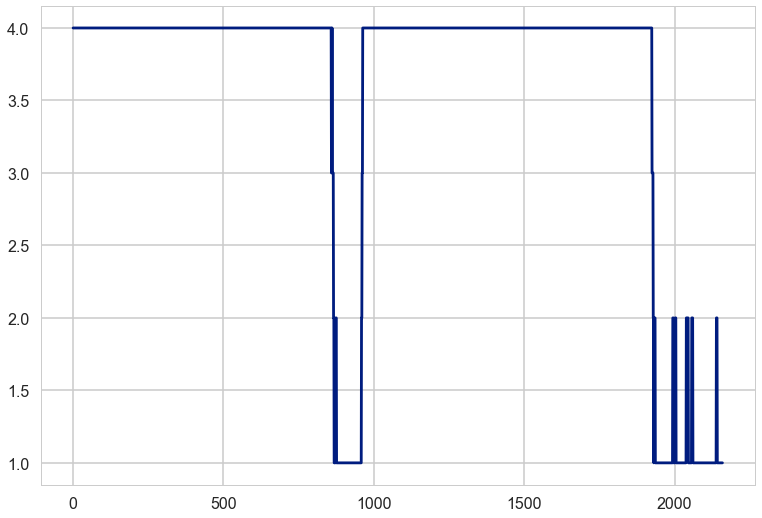

In [75]:
#n, p = training_data.shape
#for i in range(1,p):

i = 13
autocorr_data = training_data['%i'%i].dropna().reset_index(drop=True)
autocorr_data = autocorr_data.iloc[0:math.floor(len(autocorr_data)*0.75)]
autocorr_data.plot()
plt.savefig('../figures/insect/ant/distribution_%i.png'%i)
plt.show()

ADF-test allows us to verify the stablity of time series. The original time series aren't stable, since the p-value 0.053010927518986325 > 0.05. Then we do the first-order differencing and the first-order differencing is stable, the p-value is quite small.

In [76]:
ADF(autocorr_data)

(-1.8341393124910776,
 0.36364897691251796,
 14,
 2145,
 {'1%': -3.4334022810746956,
  '5%': -2.862888383494258,
  '10%': -2.567487813313338},
 -3554.4538602148614)

(-11.65052753707383,
 2.042532381070888e-21,
 13,
 2145,
 {'1%': -3.4334022810746956,
  '5%': -2.862888383494258,
  '10%': -2.567487813313338},
 -3550.39801095639)

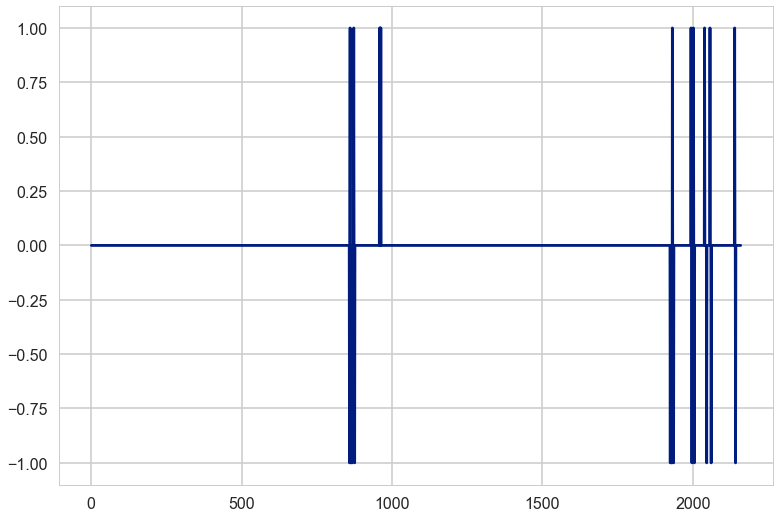

In [77]:
d_data = autocorr_data.diff().dropna()
d_data.columns = ['first-order differencing']
d_data.plot()
ADF(d_data)

We do the acf and pacf in order to find out the appropriate order of ARIMA(p, d, q)

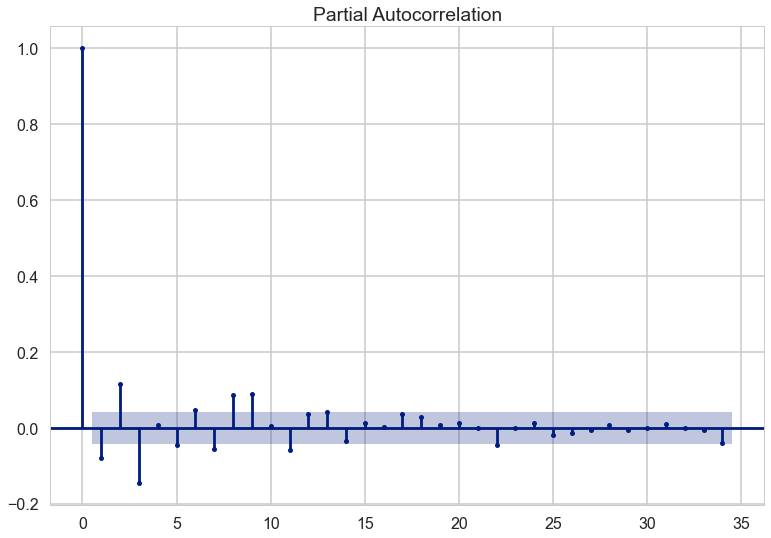

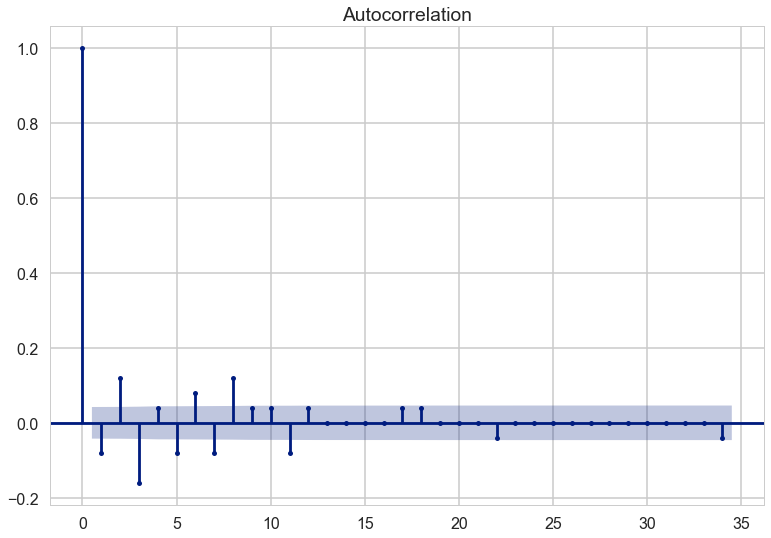

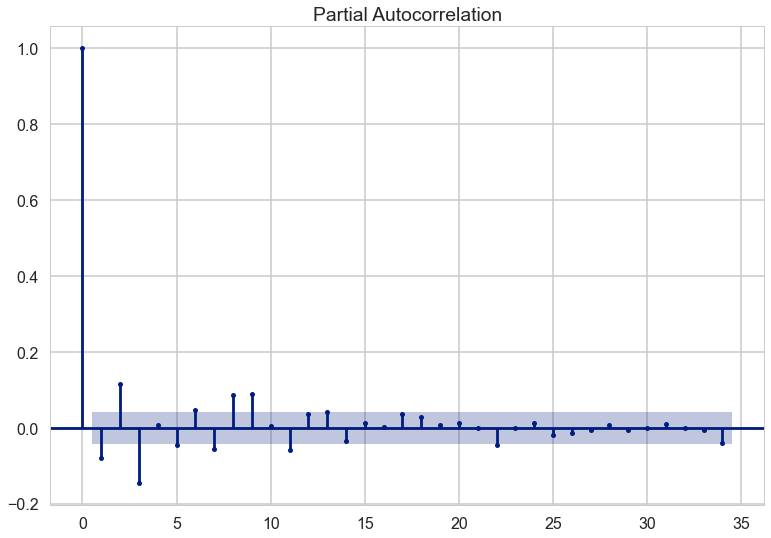

In [78]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(d_data)
plot_pacf(d_data)

In [79]:
tmp = []
for p in range(5):
    for q in range(5):
        try:
            tmp.append([ARIMA(d_data, order = (p,1,q)).fit().bic, p, q])
        except:
            tmp.append([None, p, q])
tmp = pd.DataFrame(tmp,columns = ['bic', 'p', 'q'])
print(tmp)
tmp[tmp['bic'] == tmp['bic'].min()]

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and w

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Use

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Use

            bic  p  q
0  -1826.787140  0  0
1  -3473.664190  0  1
2  -3477.330790  0  2
3  -3492.008342  0  3
4  -3528.171056  0  4
5  -2752.181690  1  0
6  -3479.763284  1  1
7  -3539.825171  1  2
8  -3540.542943  1  3
9  -3533.111522  1  4
10 -2831.381352  2  0
11 -3500.614824  2  1
12 -3540.123262  2  2
13 -3530.714620  2  3
14 -3525.800211  2  4
15 -3016.098608  3  0
16 -3538.679354  3  1
17 -3533.636232  3  2
18 -3525.936580  3  3
19 -3545.874356  3  4
20 -3083.516140  4  0
21 -3531.132734  4  1
22 -3532.778568  4  2
23 -3518.554475  4  3
24 -3536.514165  4  4


/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,bic,p,q
19,-3545.874356,3,4


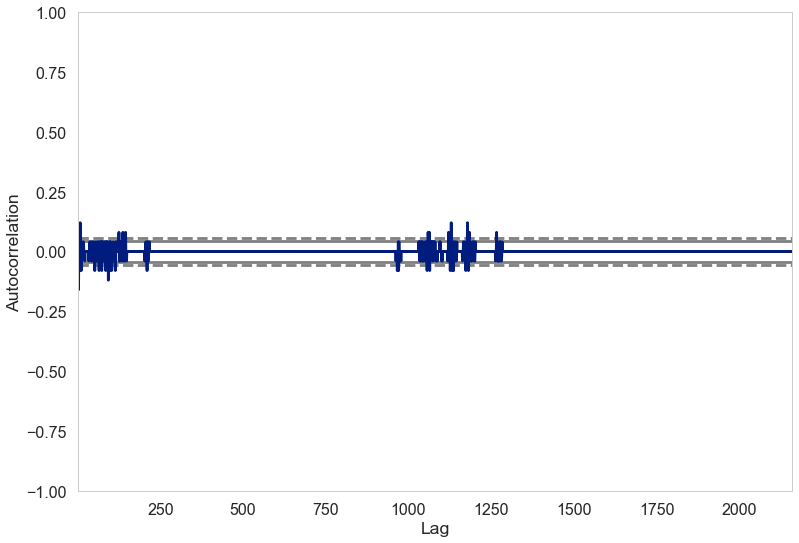

In [80]:
#Check autocorrelation plot to determine best lag time for ARIMA
autocorrelation_plot(d_data)
plt.savefig('../figures/insect/ant/autocorrelation_%i.png'%i)
plt.show()

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Use

                               SARIMAX Results                                
Dep. Variable:                     13   No. Observations:                 2159
Model:                 ARIMA(3, 1, 4)   Log Likelihood                1803.645
Date:                Fri, 02 Jul 2021   AIC                          -3591.290
Time:                        17:57:16   BIC                          -3545.874
Sample:                             0   HQIC                         -3574.678
                               - 2159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0937      0.033    -33.227      0.000      -1.158      -1.029
ar.L2         -1.0630      0.019    -55.633      0.000      -1.100      -1.026
ar.L3         -0.7716      0.015    -50.775      0.0

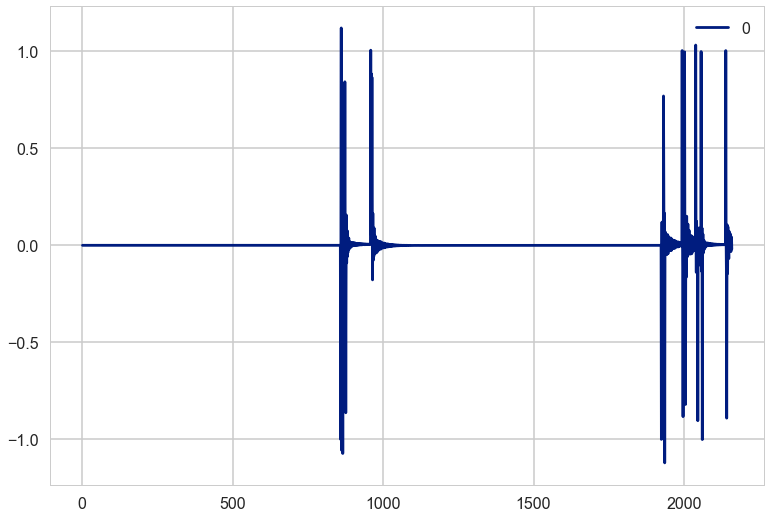

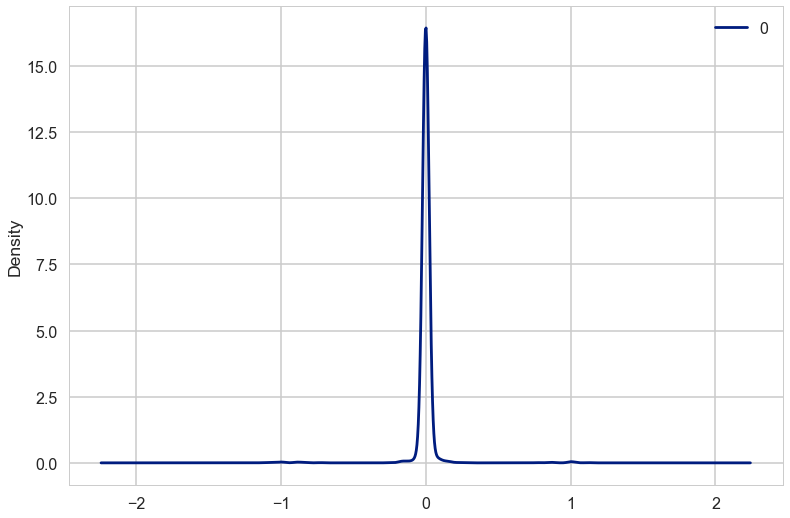

                 0
count  2159.000000
mean     -0.000904
std       0.104755
min      -1.121191
25%      -0.000323
50%       0.000000
75%       0.000000
max       1.120133


In [81]:
# def find_optimal_arima_lag
model = ARIMA(d_data, order=(3,1,4))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [82]:
import time
from core import Position, PositionType
from utils.general import change_above_threshold

"""
Liquidates a given Position and returns the new balance
"""


def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
        print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
        print(log) if verbose else None

    return updated_balance


"""
Simulation in format of:
    - If open position -> close by selling or buying back
    - Decide on next position
    - Repeat

Decisions to buy / sell happen continuously each day
"""


def simulate_trades_continuous(predictions, ground_truth, thresholds=0, slowed=False, verbose=False):
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0

    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None

        if curr_price < next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif curr_price > next_prediction:
            # check threshold
            if change_above_threshold(curr_price, next_prediction, threshold=thresholds[t]):
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log)

    return balance_over_time

In [83]:
first_df = d_data

data = first_df.reset_index(drop = True)

num_days_year = int(len(data) * 0.25)

ground_truth, start_t = first_df.to_numpy(), int(num_days_year * 0.5)

predictions = list()
thresholds = []

training_X = data[:start_t].reset_index(drop=True)
#print(training_X)
test_X = data[start_t:].reset_index(drop=True)
#print(test_X)
#print(first_df[start_t:])



In [84]:
print("Predicting ARIMA with no thresholding")
for t_i in tqdm(range(len(data) - start_t)):
    current_t = t_i + start_t
    threshold = 0
    thresholds.append(threshold)
    model = ARIMA(data[t_i:current_t], order = (10,1,0))
    fitted_model = model.fit()
    prediction = fitted_model.forecast().reset_index(drop=True)
    predictions.append(prediction[0])


  0%|          | 0/1890 [00:00<?, ?it/s]

Predicting ARIMA with no thresholding


/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 1/1890 [00:00<12:32,  2.51it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 2/1890 [00:00<12:03,  2.61it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 3/1890 [00:01<12:10,  2.58it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiza

  2%|▏         | 29/1890 [00:12<13:18,  2.33it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 30/1890 [00:12<13:46,  2.25it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 31/1890 [00:13<14:03,  2.20it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 32/1890 [00:13<14:44,  2.10it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:

  3%|▎         | 58/1890 [00:28<13:45,  2.22it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 59/1890 [00:29<13:21,  2.28it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 60/1890 [00:29<12:56,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 61/1890 [00:29<12:31,  2.43it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:

  5%|▍         | 87/1890 [00:39<11:08,  2.70it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▍         | 88/1890 [00:39<11:11,  2.68it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▍         | 89/1890 [00:40<11:23,  2.64it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▍         | 90/1890 [00:40<11:23,  2.63it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:

  6%|▌         | 116/1890 [00:53<15:14,  1.94it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▌         | 117/1890 [00:53<15:01,  1.97it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▌         | 118/1890 [00:54<14:57,  1.97it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▋         | 119/1890 [00:54<14:43,  2.01it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

  8%|▊         | 145/1890 [01:05<11:48,  2.46it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 146/1890 [01:06<12:00,  2.42it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 147/1890 [01:06<12:11,  2.38it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  8%|▊         | 148/1890 [01:07<12:15,  2.37it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

  9%|▉         | 174/1890 [01:17<12:08,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  9%|▉         | 175/1890 [01:18<12:05,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  9%|▉         | 176/1890 [01:18<12:13,  2.34it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  9%|▉         | 177/1890 [01:18<12:26,  2.30it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 11%|█         | 203/1890 [01:30<12:09,  2.31it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 11%|█         | 204/1890 [01:31<11:55,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 11%|█         | 205/1890 [01:31<11:50,  2.37it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 11%|█         | 206/1890 [01:32<11:39,  2.41it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 12%|█▏        | 232/1890 [01:42<10:39,  2.59it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 233/1890 [01:42<10:39,  2.59it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 234/1890 [01:43<10:42,  2.58it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 235/1890 [01:43<10:39,  2.59it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 14%|█▍        | 261/1890 [01:54<12:01,  2.26it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 14%|█▍        | 262/1890 [01:54<12:03,  2.25it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 14%|█▍        | 263/1890 [01:55<11:57,  2.27it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 14%|█▍        | 264/1890 [01:55<11:54,  2.28it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 15%|█▌        | 290/1890 [02:06<10:33,  2.53it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 15%|█▌        | 291/1890 [02:07<10:38,  2.51it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 15%|█▌        | 292/1890 [02:07<10:51,  2.45it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 16%|█▌        | 293/1890 [02:07<10:38,  2.50it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 17%|█▋        | 319/1890 [02:18<11:31,  2.27it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 320/1890 [02:19<11:21,  2.31it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 321/1890 [02:19<11:13,  2.33it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 17%|█▋        | 322/1890 [02:19<11:02,  2.37it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 18%|█▊        | 348/1890 [02:30<10:14,  2.51it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 18%|█▊        | 349/1890 [02:31<10:07,  2.54it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|█▊        | 350/1890 [02:31<10:15,  2.50it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|█▊        | 351/1890 [02:31<10:15,  2.50it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 20%|█▉        | 377/1890 [02:42<10:44,  2.35it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|██        | 378/1890 [02:43<11:08,  2.26it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|██        | 379/1890 [02:43<12:00,  2.10it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|██        | 380/1890 [02:44<11:52,  2.12it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 21%|██▏       | 406/1890 [02:56<12:37,  1.96it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 22%|██▏       | 407/1890 [02:56<12:18,  2.01it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 22%|██▏       | 408/1890 [02:57<11:56,  2.07it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 22%|██▏       | 409/1890 [02:57<12:09,  2.03it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 23%|██▎       | 435/1890 [03:11<13:40,  1.77it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 436/1890 [03:12<13:19,  1.82it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 437/1890 [03:12<13:14,  1.83it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 438/1890 [03:13<13:02,  1.86it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 25%|██▍       | 464/1890 [03:26<11:20,  2.10it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 25%|██▍       | 465/1890 [03:26<11:24,  2.08it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 25%|██▍       | 466/1890 [03:27<11:25,  2.08it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 25%|██▍       | 467/1890 [03:27<11:20,  2.09it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 26%|██▌       | 493/1890 [03:40<12:04,  1.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|██▌       | 494/1890 [03:40<12:05,  1.92it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|██▌       | 495/1890 [03:41<12:03,  1.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 26%|██▌       | 496/1890 [03:41<12:03,  1.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 28%|██▊       | 522/1890 [03:56<12:35,  1.81it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 28%|██▊       | 523/1890 [03:56<12:55,  1.76it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 28%|██▊       | 524/1890 [03:57<12:23,  1.84it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 28%|██▊       | 525/1890 [03:57<12:31,  1.82it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 29%|██▉       | 551/1890 [04:15<16:36,  1.34it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 29%|██▉       | 552/1890 [04:16<16:29,  1.35it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 29%|██▉       | 553/1890 [04:17<16:06,  1.38it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 29%|██▉       | 554/1890 [04:18<16:13,  1.37it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 31%|███       | 580/1890 [04:35<12:40,  1.72it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 31%|███       | 581/1890 [04:36<12:50,  1.70it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 31%|███       | 582/1890 [04:36<12:43,  1.71it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 31%|███       | 583/1890 [04:37<12:39,  1.72it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 32%|███▏      | 609/1890 [05:00<21:37,  1.01s/it]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|███▏      | 610/1890 [05:01<21:07,  1.01it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|███▏      | 611/1890 [05:02<20:43,  1.03it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 46%|████▌     | 863/1890 [06:47<12:03,  1.42it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 52%|█████▏    | 975/1890 [07:41<07:13,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|█████▏    | 976/1890 [07:42<07:12,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|█████▏    | 977/1890 [07:42<07:13,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|█████▏    | 978/1890 [07:43<07:10,  2.12it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

 53%|█████▎    | 1004/1890 [07:56<06:59,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 53%|█████▎    | 1005/1890 [07:56<06:53,  2.14it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 53%|█████▎    | 1006/1890 [07:57<06:46,  2.18it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 53%|█████▎    | 1007/1890 [07:57<06:41,  2.20it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 55%|█████▍    | 1032/1890 [08:08<06:30,  2.20it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|█████▍    | 1033/1890 [08:08<06:30,  2.20it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|█████▍    | 1034/1890 [08:09<06:38,  2.15it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|█████▍    | 1035/1890 [08:09<06:43,  2.12it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 56%|█████▌    | 1060/1890 [08:22<07:19,  1.89it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 56%|█████▌    | 1061/1890 [08:23<07:11,  1.92it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 56%|█████▌    | 1062/1890 [08:23<07:02,  1.96it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 56%|█████▌    | 1063/1890 [08:24<06:57,  1.98it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 58%|█████▊    | 1088/1890 [08:35<05:42,  2.34it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|█████▊    | 1089/1890 [08:35<05:43,  2.33it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|█████▊    | 1090/1890 [08:36<05:43,  2.33it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|█████▊    | 1091/1890 [08:36<05:47,  2.30it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 59%|█████▉    | 1116/1890 [08:49<07:25,  1.74it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 59%|█████▉    | 1117/1890 [08:50<07:50,  1.64it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 59%|█████▉    | 1118/1890 [08:51<07:46,  1.66it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 59%|█████▉    | 1119/1890 [08:51<07:40,  1.67it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 61%|██████    | 1144/1890 [09:03<05:47,  2.14it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████    | 1145/1890 [09:04<05:46,  2.15it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████    | 1146/1890 [09:04<05:45,  2.16it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 61%|██████    | 1147/1890 [09:05<05:42,  2.17it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 62%|██████▏   | 1172/1890 [09:17<06:29,  1.85it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 62%|██████▏   | 1173/1890 [09:18<06:25,  1.86it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 62%|██████▏   | 1174/1890 [09:18<06:29,  1.84it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 62%|██████▏   | 1175/1890 [09:19<06:26,  1.85it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 63%|██████▎   | 1200/1890 [09:32<05:01,  2.29it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████▎   | 1201/1890 [09:32<04:57,  2.32it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████▎   | 1202/1890 [09:32<04:55,  2.33it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████▎   | 1203/1890 [09:33<04:57,  2.31it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 65%|██████▍   | 1228/1890 [09:44<05:22,  2.05it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 65%|██████▌   | 1229/1890 [09:45<05:31,  1.99it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 65%|██████▌   | 1230/1890 [09:45<05:41,  1.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 65%|██████▌   | 1231/1890 [09:46<05:40,  1.93it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 66%|██████▋   | 1256/1890 [10:00<06:30,  1.62it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 1257/1890 [10:01<06:31,  1.62it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 1258/1890 [10:01<06:38,  1.59it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 1259/1890 [10:02<06:24,  1.64it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 68%|██████▊   | 1284/1890 [10:19<07:14,  1.40it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|██████▊   | 1285/1890 [10:20<07:09,  1.41it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|██████▊   | 1286/1890 [10:20<07:01,  1.43it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|██████▊   | 1287/1890 [10:21<07:00,  1.43it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 69%|██████▉   | 1312/1890 [10:42<07:28,  1.29it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 69%|██████▉   | 1313/1890 [10:43<07:17,  1.32it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 70%|██████▉   | 1314/1890 [10:43<06:51,  1.40it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 70%|██████▉   | 1315/1890 [10:44<06:28,  1.48it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 71%|███████   | 1340/1890 [10:57<04:27,  2.05it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|███████   | 1341/1890 [10:57<04:28,  2.05it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|███████   | 1342/1890 [10:58<04:23,  2.08it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|███████   | 1343/1890 [10:58<04:20,  2.10it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 72%|███████▏  | 1368/1890 [11:10<04:05,  2.12it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 72%|███████▏  | 1369/1890 [11:10<04:06,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 72%|███████▏  | 1370/1890 [11:11<04:00,  2.17it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 73%|███████▎  | 1371/1890 [11:11<03:56,  2.19it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 74%|███████▍  | 1396/1890 [11:22<03:39,  2.25it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████▍  | 1397/1890 [11:22<03:40,  2.23it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████▍  | 1398/1890 [11:23<03:41,  2.22it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████▍  | 1399/1890 [11:23<03:42,  2.21it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 75%|███████▌  | 1424/1890 [11:35<03:34,  2.17it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 75%|███████▌  | 1425/1890 [11:36<03:30,  2.21it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 75%|███████▌  | 1426/1890 [11:36<03:27,  2.24it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 76%|███████▌  | 1427/1890 [11:37<03:24,  2.26it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 77%|███████▋  | 1452/1890 [11:48<03:21,  2.18it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|███████▋  | 1453/1890 [11:48<03:21,  2.17it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|███████▋  | 1454/1890 [11:48<03:22,  2.15it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|███████▋  | 1455/1890 [11:49<03:21,  2.16it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 78%|███████▊  | 1480/1890 [12:00<02:53,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 78%|███████▊  | 1481/1890 [12:01<02:50,  2.40it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 78%|███████▊  | 1482/1890 [12:01<02:48,  2.42it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 78%|███████▊  | 1483/1890 [12:02<02:46,  2.45it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 80%|███████▉  | 1508/1890 [12:12<03:02,  2.09it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|███████▉  | 1509/1890 [12:13<03:00,  2.11it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|███████▉  | 1510/1890 [12:13<03:02,  2.08it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|███████▉  | 1511/1890 [12:14<03:00,  2.10it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 81%|████████▏ | 1536/1890 [12:26<02:33,  2.30it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 81%|████████▏ | 1537/1890 [12:26<02:31,  2.32it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 81%|████████▏ | 1538/1890 [12:27<02:28,  2.37it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 81%|████████▏ | 1539/1890 [12:27<02:25,  2.41it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 83%|████████▎ | 1564/1890 [12:37<02:24,  2.25it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|████████▎ | 1565/1890 [12:38<02:24,  2.24it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|████████▎ | 1566/1890 [12:38<02:29,  2.17it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|████████▎ | 1567/1890 [12:39<02:27,  2.19it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 84%|████████▍ | 1592/1890 [12:51<02:11,  2.26it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|████████▍ | 1593/1890 [12:51<02:09,  2.29it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|████████▍ | 1594/1890 [12:51<02:07,  2.32it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|████████▍ | 1595/1890 [12:52<02:05,  2.36it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 86%|████████▌ | 1620/1890 [13:03<02:39,  1.69it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|████████▌ | 1621/1890 [13:04<02:41,  1.66it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|████████▌ | 1622/1890 [13:05<02:47,  1.60it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|████████▌ | 1623/1890 [13:05<02:59,  1.49it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

 87%|████████▋ | 1648/1890 [13:23<02:17,  1.75it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|████████▋ | 1649/1890 [13:24<02:12,  1.81it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|████████▋ | 1650/1890 [13:24<02:09,  1.86it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|████████▋ | 1651/1890 [13:25<02:08,  1.87it/s]/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

In [86]:
print(predictions)
print(first_df)
print(len(predictions))
print(len(first_df[start_t:]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

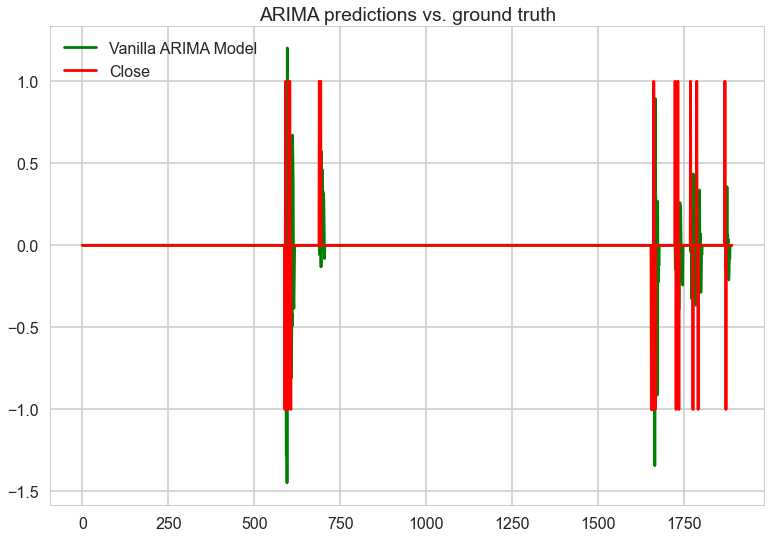

In [87]:
#print("RMSE of forecasting: ", sqrt(mean_squared_error(test_X, predictions)))
#balances_arima = simulate_trades_continuous(predictions, ground_truth[start_t:], thresholds)

plot_time_series(ts_1=predictions, ts_label_1='Vanilla ARIMA Model', ts_2=first_df[start_t:], ts_label_2='Close', title='ARIMA predictions vs. ground truth')
#plot_balance(data=balances_arima)

In [88]:
print(autocorr_data[0])

4


In [103]:
predictions_original = list()
predictions_original.append(autocorr_data[start_t]+predictions[0])
for i in range(1, len(predictions)):
    predictions_original.append(predictions[i]+predictions_original[i-1])

In [108]:
print(len(autocorr_data[start_t+1:]))
print(len(predictions_original))

1890
1890
4.0
4


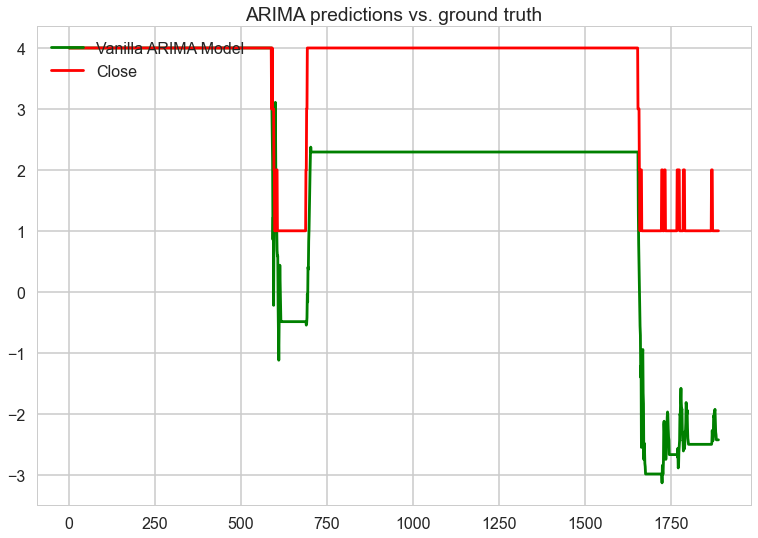

In [105]:
plot_time_series(ts_1=predictions_original, ts_label_1='Vanilla ARIMA Model', ts_2=autocorr_data[start_t+1:], ts_label_2='Close', title='ARIMA predictions vs. ground truth')

# Grid searching ARIMA parameters

In [41]:
def evaluate_ARIMA_profit(data, order):
    num_days_year = 253
    ground_truth, start_t = data, int(num_days_year/2)
    assert len(data) > start_t

    predictions = list()
    thresholds = []
    training_X = data[:start_t].reset_index(drop=True)

    test_X = data[start_t:].reset_index(drop=True)

#     print("Predicting ARIMA with no thresholding")
    for t_i in (range(len(data) - start_t)):
        current_t = t_i + start_t
        threshold = 0
        thresholds.append(threshold)
        model = ARIMA(data[:current_t], order = order)
        fitted_model = model.fit()
        prediction = fitted_model.forecast().reset_index(drop=True)
        predictions.append(prediction[0])

#     print("RMSE of forecasting: ", sqrt(mean_squared_error(test_X, predictions)))
    balances_arima = simulate_trades_continuous(predictions, ground_truth[start_t:], thresholds)
    return balances_arima[len(balances_arima)-1]

def gridsearch_ARIMA(data, p_values, d_values, q_values):
    best_profit, best_order = -9999999, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    balance = evaluate_ARIMA_profit(data, order)
                    if balance > best_profit:
                        best_profit, best_order = balance, order
                except:
                    continue
#     print('Best ARIMA%s Balance=%.3f' % (best_profit, best_order))
    return best_order

In [ ]:
first_df = training_data.loc["AAPL"].dropna()

data = first_df.reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df.to_numpy(), int(num_days_year/2)

predictions = list()
thresholds = []
training_X = data[:start_t].reset_index(drop=True)

test_X = data[start_t:].reset_index(drop=True)
p_values = [1, 5, 10, 25]
d_values = range(0, 2)
q_values = range(0, 2)
ideal_order = gridsearch_ARIMA(data[:start_t*2], p_values, d_values, q_values)


In [ ]:
print(ideal_order)